# Description
The problem we're trying to solve in this competition is to build a machine learning model to accurately identify cancer in small image patches of lymph node tissue. The dataset contains images of histopathologic scans that have been labeled as positive or negative. By being able to accurately identifying these, it can play a crucial role in improving patient outcomes. We'll be using convolutional neural networks (CNN) along with other techniques like data augmentation and hyperparameter tuning to improve our accuracy.

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
# Load the data (training and test samples are in these separate directories)
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Load the labels
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Exploratory Data Analysis (EDA)

In [27]:
# check for null/missing values
labels.isnull().sum()

id       0
label    0
dtype: int64

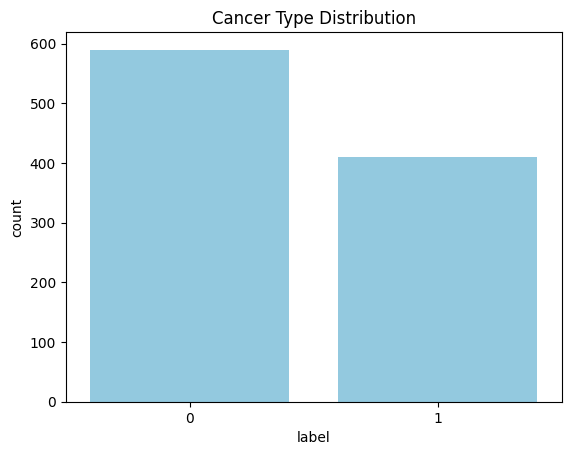

In [43]:
# class distribution exploration
sns.countplot(x='label', data=labels, color='skyblue')
plt.title('Cancer Type Distribution')
plt.show()

In [44]:
# Shows sample images of metastatic and non-metatstic images
def show_sample_images(label, num_samples=5):
    sample_ids = labels[labels['label'] == label]['id'].sample(num_samples).values
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for idx, img_id in enumerate(sample_ids):
        img_path = os.path.join(train_dir, img_id + '.tif')
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'Label: {label}')

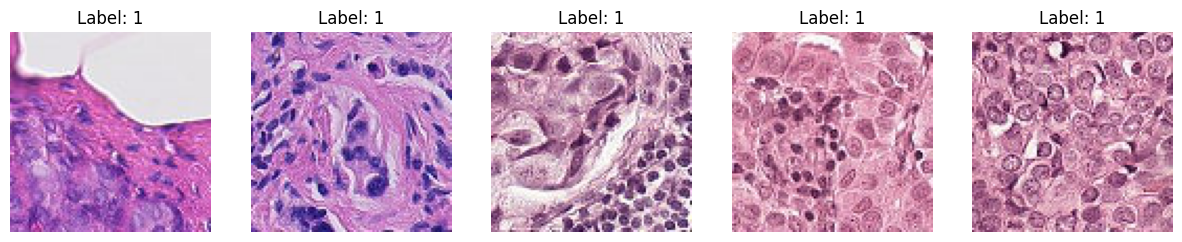

In [45]:
show_sample_images(label=1)  # Visualize metastatic images

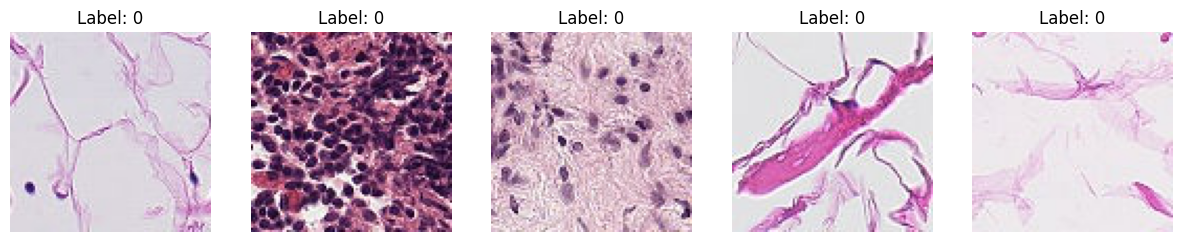

In [46]:
show_sample_images(label=0)  # Visualize non-metastatic images

**EDA Summary**
* The label distribution indicates that the training dataset contains more non-metastatic tissues.
* Sample images picked from the training dataset show that the two labels have differing brightness and textures, implying potential challenges for the model.
* Because of labels imbalance, we might need to perform some data augmentation to improve generalization.
* Will also need to do normalization to standarize the input to feed into CNN.

# Model Architecture

**Model 1: Simple CNN**

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build a simple CNN
def build_simple_cnn(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

simple_cnn = build_simple_cnn()
simple_cnn.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

**Model 2: Advanced/deeper CNN**

In [31]:
def build_deeper_cnn(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

deeper_cnn = build_deeper_cnn()
deeper_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,561 (12.86 MB)

 Trainable params: 3,370,561 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

**Simple vs Advanced CNN**
* Advanced CNN has more convolutional layers, allowing each additional layer to learn more complex and abstract features.
* Simple CNN has layers with 32 filters and 64 filters. Advanced CNN has an additional layer with 128 filters. The large number of filters allows the deeper CNN to detect more complex patterns.
* Simple CNN runs faster than advanced CNN.
* Simple CNN may underfit the data, meaning it may not capture all the complexity, but it's less likely to overfit and may generalize well.
* Deeper CNN can learn more complex patterns, but may be in risk of overfitting. This is why deeper CNN includes a dropout layer of 50% to migitate overfitting by randomly disabling neurons during training.

# Results and Analysis

In [32]:
# Prepare the data by splitting them
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(labels, test_size=0.2, stratify=labels['label'], random_state=42)

In [33]:
# Convert labels to strings
train_labels['label'] = train_labels['label'].astype(str)
test_labels['label'] = test_labels['label'].astype(str)

train_labels['filename'] = train_labels['id'] + '.tif'
test_labels['filename'] = test_labels['id'] + '.tif'

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',  
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=train_dir,
    x_col='filename',  
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [34]:
# Compile the models
simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deeper_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Training the simple model
simple_cnn_train = simple_cnn.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5156 - loss: 1.1260 - val_accuracy: 0.5900 - val_loss: 0.6703
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.5732 - loss: 0.6565 - val_accuracy: 0.5900 - val_loss: 0.6565
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6266 - loss: 0.6075 - val_accuracy: 0.6100 - val_loss: 0.6252
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6276 - loss: 0.6099 - val_accuracy: 0.6250 - val_loss: 0.6063
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6814 - loss: 0.5811 - val_accuracy: 0.7100 - val_loss: 0.5995


In [36]:
# Training the deeper model
deeper_cnn_train = deeper_cnn.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5633 - loss: 0.7213 - val_accuracy: 0.7300 - val_loss: 0.6486
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7185 - loss: 0.6058 - val_accuracy: 0.6950 - val_loss: 0.6163
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7309 - loss: 0.5374 - val_accuracy: 0.7050 - val_loss: 0.5681
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7579 - loss: 0.5073 - val_accuracy: 0.7450 - val_loss: 0.5685
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7586 - loss: 0.5021 - val_accuracy: 0.7400 - val_loss: 0.5513


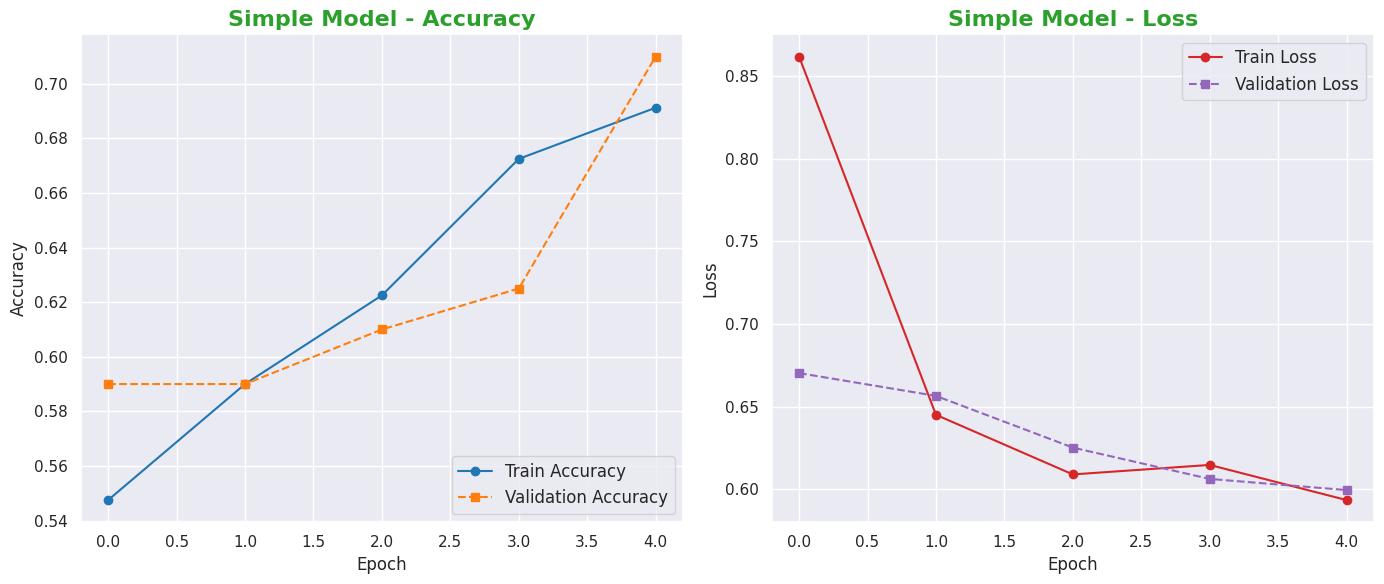

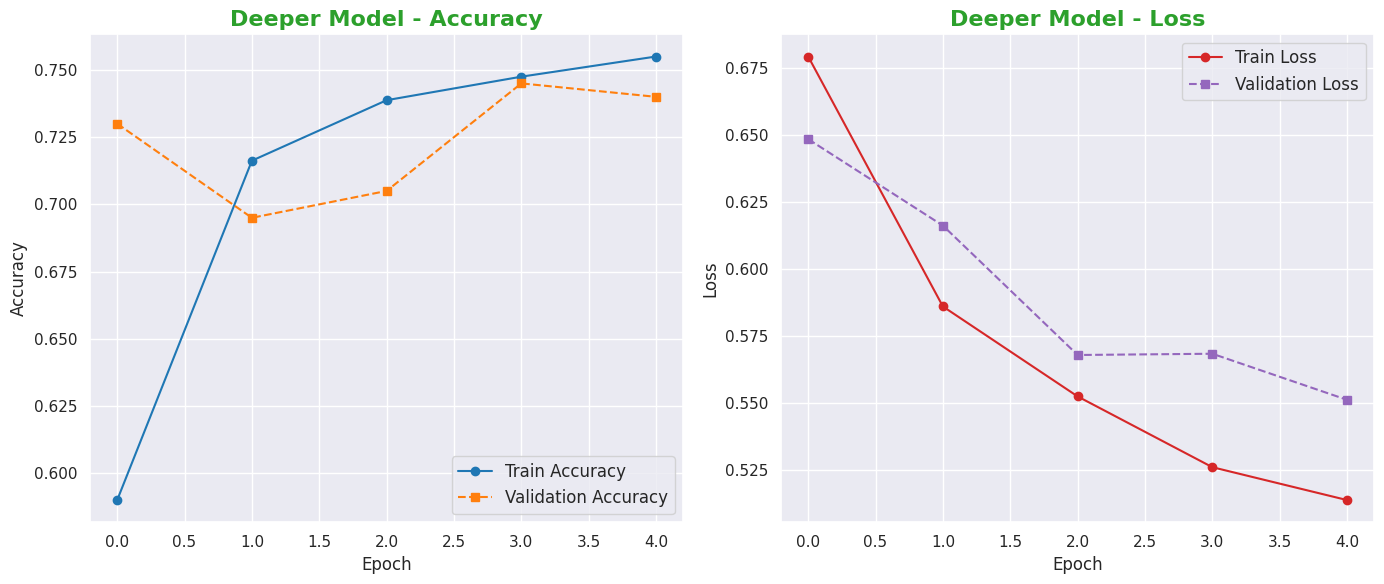

In [48]:
# Plot the results
# Use Seaborn styling for a cooler look
sns.set(style="darkgrid")

def plot_history(history, title):
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle='-', marker='o', markersize=6)  # Solid line with markers
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linestyle='--', marker='s', markersize=6)  # Dashed line with square markers
    plt.title(f'{title} - Accuracy', fontsize=16, fontweight='bold', color='#2ca02c')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='#d62728', linestyle='-', marker='o', markersize=6)  # Solid line with markers
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#9467bd', linestyle='--', marker='s', markersize=6)  # Dashed line with square markers
    plt.title(f'{title} - Loss', fontsize=16, fontweight='bold', color='#2ca02c')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)

    # Tight layout to make space for titles and labels
    plt.tight_layout()
    plt.show()

# Plot history using the modified function
plot_history(simple_cnn_train, 'Simple Model')
plot_history(deeper_cnn_train, 'Deeper Model')

**Findings**
* The advanced, deeper model shows much better accuracy and lower loss value.
* Advanced model also reduced overfitting compared to the simple model.
* Data augmentation and dropout layers in the advanced model helped improve generalization.

**Hyperparameter Tuning**
* Learning rate: A smaller learning rate improved the generalization of the training and prevented overshooting. However, too small of a learning rate would make the training run a long time, so need to find one that is not too small and not too large.
* I've also tried adjusting the batch sizes (16, 32, 64). Size 32 provided the best overall balance between training speed and model performance.
* Number of epochs could also be tweaked. I've tried 5, 10, 20. 5 epochs was just right and didn't overfit.

**Conclusion**
* The advanced model outperformed the simple model in accuracy and minimizing loss function.
* Data augmentation was crucial here in mitigating overfitting issues and improving generalization

# Submission

In [38]:
# Load the test files
test_files = os.listdir(test_dir)
test_df = pd.DataFrame({'filename': test_files})

In [41]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

pred = deeper_cnn.predict(test_generator, verbose=1)
test_df['id'] = test_df['filename'].str.replace('.tif', '', regex=False)
test_df['label'] = pred
final_df = test_df[['id', 'label']]

final_df['label'] = final_df['label'].clip(0, 1)
final_df.to_csv('submission.csv', index=False)

Found 1000 validated image filenames.
 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


/tmp/ipykernel_30/1245796614.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['label'] = final_df['label'].clip(0, 1)


In [42]:
final_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.225018
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.061957
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.428880
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.613991
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.335084
